The <b>Black-Scholes</b> is a mathematical method to model the dynamics of a derivative instrument. Its formula estimates the theoretical value of European-style options and shows that the option has a unique price given the security and its expected return.

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from pandas_datareader.data import DataReader

The <b>Black-Scholes call option price $C$ </b>is calculated by subtracting the present value of the strike price $K$ multiplied by the risk-adjusted probability that the option will be exercised $N(d_2)$, of the product of the stock price $S$ and the probability of receiving the stock at the expiration of the option contract $N(d_1)$.

$$C = SN(d_1) - K e^{-rt} N(d_2)$$

$$d_1 = \frac{ln_K^S + (r+ \frac{\sigma^2}{2} \Delta t) }{\sigma  \sqrt{\Delta t}}$$

$$d_2 = d_1 - \sigma \sqrt{\Delta t}$$

where:
1. $C$ - Call option price
2. $S$ - Current stock price (or other underlying instrument)
3. $K$ - Strike price
4. $r$ - Risk-free interest rate
5. $\Delta t$ - Time to maturity (T-t)
6. $N$ - Normal distribution
7. $\sigma$ - Volatility of the asset
8. $N(d_1)$ - Probability of receiving the stock at the expiration of our option contract. (The expected value of the receipt of the stock is contingent on the exercise of the option. It is, therefore, the product of the conditional expected value of the receipt of the stock given that exercise has occurred times the probability of exercise)
9. $N(d_2)$ - Risk-adjusted probability that the option will be exercised

Assumptions:
1. Constant volatility is assumed, although this may not be the case. Replacing this term with stochastic-process generated volatility would reduce error.
2. Returns are assumed to be normally distributed.
3. Risk-free rate is hypothetical assuming that all payment obligations are met.
4. The underlying stock does not pay dividends during the option contract. This can be adjusted by subtracting the discounted value of a future dividend from the stock price.
5. Assumes that markets function efficiently and are perfectly liquid, with the stock price moving independently and possibility to buy or sell any amount at any given time.

In [2]:
def d1(S, K, r, dt, sigma):
    return (np.log(S/K) + (r + np.sqrt(sigma) * .5 * dt)) / (sigma * np.sqrt(dt))

def d2(S, K, r, dt, sigma):
    return d1(S, K, r, dt, sigma) - sigma * np.sqrt(dt)

def call(S, K, r, dt, sigma):
    return S * norm.cdf(d1(S, K, r, dt, sigma)) - K * np.exp(-r * dt) * norm.cdf(d2(S, K, r, dt, sigma))

<b>Vanilla Options</b> are financial instruments that give the holder the right, but not the obligation, to buy or sell an underlying asset at a predetermined price within a given time window. <b>European options</b> are a type of vanilla options that can be exercised at the expiry date. Such options are used by individuals or companies to hedge their exposure in a particular asset or to speculate on the price movement of a financial instrument.

In the below data cell, we are querying price data for 1 year for a sample stock in our case Tesla from Yahoo Finance. And we set the risk-free rate to a 30 year U.S. treasury yield:

In [3]:
date = datetime.datetime.now()
date_m1 = date - datetime.timedelta(365)

df = DataReader('TSLA', 'yahoo', date_m1, date).sort_values('Date')
df['rel_day_returns'] = (df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)
display(df)

trsry30_yield = DataReader('^TNX', 'yahoo', date - datetime.timedelta(1), date)['Close'].iloc[0]
display(trsry30_yield)

,High,Low,Open,Close,Volume,Adj Close,rel_day_returns
Date,,,,,,,
2021-09-30,263.043335,258.333344,260.333344,258.493347,53868000.0,258.493347,NaN
2021-10-01,260.260010,254.529999,259.466675,258.406677,51094200.0,258.406677,-0.000335
2021-10-04,268.989990,258.706665,265.500000,260.510010,91449900.0,260.510010,0.008140
2021-10-05,265.769989,258.066681,261.600006,260.196655,55297800.0,260.196655,-0.001203
2021-10-06,262.220001,257.739990,258.733337,260.916656,43898400.0,260.916656,0.002767
...,...,...,...,...,...,...,...
2022-09-26,284.089996,270.309998,271.829987,276.010010,58076900.0,276.010010,0.002470
2022-09-27,288.670013,277.510010,283.839996,282.940002,61925200.0,282.940002,0.025108
2022-09-28,289.000000,277.570007,283.079987,287.809998,54664800.0,287.809998,0.017212


3.746999979019165

In [4]:
S = df['Close'].iloc[-1]
K = 270
r = trsry30_yield / 100.
dt = 30 / 360
sigma = np.sqrt(df.index.unique().shape[0]) * df['rel_day_returns'].std()

In [5]:
C = call(S, K, r, dt, sigma)
C

21.339509976201498

Parameters impacting option price:

In [6]:
expiry_time_range = range(1,361)
expiry_time_effect = [call(S, K, r, tx/360, sigma) for tx in expiry_time_range]

volatility_range = np.linspace(0, 0.7, 50)
volatility_effect = [call(S, K, r, dt, sigmax) for sigmax in volatility_range]

strike_range = range(250, 291)
strike_effect = [call(S, Kx, r, dt, sigma) for Kx in strike_range]

underlying_price_range = range(250, 291)
underlying_price_effect = [call(Sx, K, r, dt, sigma) for Sx in underlying_price_range]

<ipython-input-2-f5ebf365f591>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (np.log(S/K) + (r + np.sqrt(sigma) * .5 * dt)) / (sigma * np.sqrt(dt))


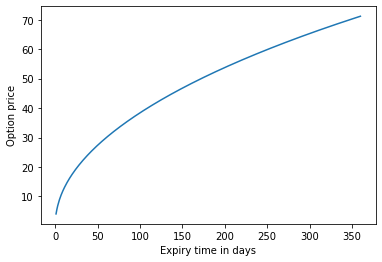

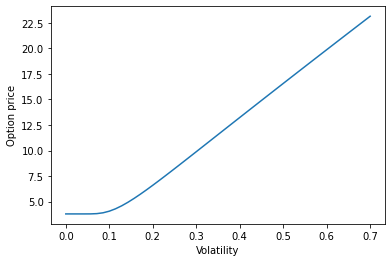

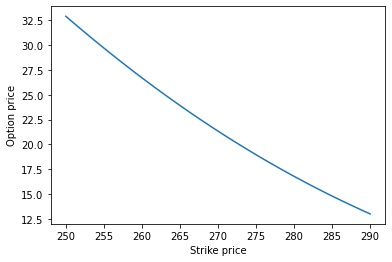

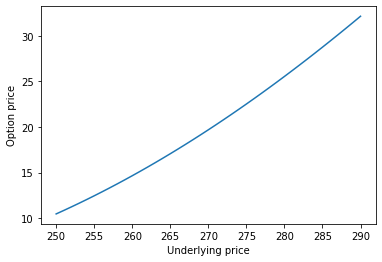

In [7]:
plt.plot(expiry_time_range, expiry_time_effect)
plt.xlabel('Expiry time in days')
plt.ylabel('Option price')
plt.show()

plt.plot(volatility_range, volatility_effect)
plt.xlabel('Volatility')
plt.ylabel('Option price')
plt.show()

plt.plot(strike_range, strike_effect)
plt.xlabel('Strike price')
plt.ylabel('Option price')
plt.show()

plt.plot(underlying_price_range, underlying_price_effect)
plt.xlabel('Underlying price')
plt.ylabel('Option price')
plt.show()


<b>Monte Carlo simulation for a vanilla option;</b> In this case we simulate the price of the underlying by multiplying it with a random sample from a normal distribution. We only consider simulated paths where the simulated price is above the strike price $K$ otherwise it would equally economical to buy the underlying at the expiry of the contract. The difference of the stock price and the strike price gives us a contract price for that simulation. The average of all simulations would give us a more realistic option price, should the stock have evolved differently. This method can be used to test for other uncertainty in the underlying, or other more complicated features.

In [8]:
simulated_option_prices = []
simulations = int(1e4)
for i in range(simulations):
    sim_price = S * np.exp(r * dt - .5 * np.power(sigma,2) * dt + sigma * np.random.randn() * np.sqrt(dt))
    simulated_option_prices.append((sim_price - K) * np.where(sim_price > K, 1, 0) * np.exp(-r))

In [9]:
mc_C = pd.Series(simulated_option_prices).mean()
print(mc_C, C)

21.569408585024103 21.339509976201498
